<h1>Tutorial of layer visualization for multi-label case</h1>

This notebook is provided to show the usage of UMAP for multiple label case. Please see another notebook <b>‘Tutorial of layer visualization’</b> as the first step.

NOTE: The script used 3rd module <a href=https://github.com/lmcinnes/umap>UMAP</a> for layer plotting.

<h2>1. Preparation</h2>

In this notebook, few packages are necessary. 

Assuming that we are in <b>'root-of-autoBioSeqpy/notebook'</b>, then we need to add the search path and import the modules.

Please install <b>UMAP, matplotlib, tensorFlow and keras</b> before using this notebook.

In [1]:
import os, sys
sys.path.append('../tool/libs')
sys.path.append('../')
oriPath = os.path.curdir
import paraParser
import moduleRead
import dataProcess
#import analysisPlot
import numpy as np
#from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
import tensorflow as tf
from utils import TextDecorate, evalStrList
from keras.models import Model
from keras.models import Sequential

import umap
import umap.plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Using <a href=https://github.com/lmcinnes/umap>UMAP</a> is a simple way for model visualization, but still we need the model as well as the data for generating the predicted data for plotting. Thus, here we need few steps to get a built model and the related data.

<h3>1.1 Model building</h3>

Like the binary case, using running.py  could build a model:

<b>python running.py --dataType protein --dataEncodingType dict  --dataTrainFilePaths examples/Gramnegativebacterialsecretedproteins/data/T1SS_train.txt examples/Gramnegativebacterialsecretedproteins/data/T2SS_train.txt examples/Gramnegativebacterialsecretedproteins/data/T3SS_train.txt examples/Gramnegativebacterialsecretedproteins/data/T4SS_train.txt examples/Gramnegativebacterialsecretedproteins/data/T5SS_train.txt examples/Gramnegativebacterialsecretedproteins/data/T7SS_train.txt --dataTrainLabel 0 1 2 3 4 5 --dataTestFilePaths examples/Gramnegativebacterialsecretedproteins/data/T1SS_test.txt examples/Gramnegativebacterialsecretedproteins/data/T2SS_test.txt examples/Gramnegativebacterialsecretedproteins/data/T3SS_test.txt examples/Gramnegativebacterialsecretedproteins/data/T4SS_test.txt examples/Gramnegativebacterialsecretedproteins/data/T5SS_test.txt examples/Gramnegativebacterialsecretedproteins/data/T7SS_test.txt --dataTestLabel 0 1 2 3 4 5 --modelLoadFile examples/Gramnegativebacterialsecretedproteins/model/protein_CNN1D+GlobalMaxPooling_model.py --verbose 1 --outSaveFolderPath tmpOut --savePrediction 1 --saveFig 1 --batch_size 40 --epochs 50 --spcLen 2000 --shuffleDataTrain 1 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt --labelToMat 1
</b>

The outputs will be saved at <b>../tmpOut</b>, including the parameters, the path of the data and constructure of the model.

If users would like to use their own model, please don't forget to save the model and the weight by using parameters "--modelSaveName" and "--weightSaveName".

<h3>1.2 Parameter pasering and data loading</h3>
The parameters are saved in <b>../tmoOut/parameters.txt</b>, we can get the information easily by using the <b>paraParser</b> module.

In [2]:
paraFile = '../tmpOut/parameters.txt'
paraDict = paraParser.parseParametersFromFile(paraFile)
#print
for k in paraDict:
    print('%r: %r' %(k,paraDict[k]))

'dataType': ['protein']
'dataEncodingType': ['dict']
'spcLen': [2000]
'firstKernelSize': []
'dataTrainFilePaths': ['examples/Gramnegativebacterialsecretedproteins/data/T1SS_train.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T2SS_train.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T3SS_train.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T4SS_train.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T5SS_train.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T7SS_train.txt']
'dataTrainLabel': [0, 1, 2, 3, 4, 5]
'dataTestFilePaths': ['examples/Gramnegativebacterialsecretedproteins/data/T1SS_test.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T2SS_test.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T3SS_test.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T4SS_test.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T5SS_test.txt', 'examples/Gramnegativebacterialsecretedproteins/data/T7SS_tes

Then using <b>predicting</b> module could help us get the model and the datasets.

In [3]:
import predicting

Here we need some modification to specify the dataset due to the layer plotting needs the training dataset.

In [4]:
paraDict['dataTestFilePaths'] = paraDict['dataTrainFilePaths']
paraDict['dataTestModelInd'] = paraDict['dataTrainModelInd']
paraDict['dataTestLabel'] = paraDict['dataTrainLabel']

In [5]:
os.chdir('../')#to the root path of autoBioSeqpy

In [6]:
predictedLabel,predicted_Probability,testNameLists,testDataMats,testLabelArr,model = predicting.predict(paraDict)    

Enconding protein data for model 0 ...
Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...
Begin to generate test dataset...
Test datasets generated.
Since labelToMat is set, the labels would be changed to onehot-like matrix
begin to prepare model...
Checking module file for modeling
Loading module and weight file
Building model...
Module loaded, generating the summary of the module
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         6656      
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         320250    
_________________________________________________________________
global_max_pooling1d (G

Please note that the test label will NOT used for predicting, thus we have to generate it manually.

In [7]:
dataLoaders = []
for i,dataPath in enumerate(paraDict['dataTestFilePaths']):
    featureGenerator =  dataProcess.ProteinFeatureGenerator('protein', useKMer=False)
    dataLoader = dataProcess.DataLoader(label = paraDict['dataTestLabel'][i], featureGenerator=featureGenerator)
    dataLoader.readFile(dataPath, spcLen = paraDict['spcLen'][0])
    dataLoaders.append(dataLoader)
testLabelArrs = []
testDataSetCreator = dataProcess.DataSetCreator(dataLoaders)
testDataMat, testLabelArr, nameList = testDataSetCreator.getDataSet(toShuffle=False, withNameList=True)
oriLabel = testLabelArr

Few printing operations for display the current information.

In [8]:
testLabelArr.shape

(667,)

In [9]:
print('%d matrix generated:\n' %(len(testDataMats)))
for i in range(len(testDataMats)):
    print('Matrix and label %d:' %i)
    print(testDataMats[i])
    print(testLabelArr)
    print('\n')

1 matrix generated:

Matrix and label 0:
[[12  9 10 ... 20 20 20]
 [12  0  9 ... 20 20 20]
 [12  2  6 ... 10  9  4]
 ...
 [12 17 17 ... 20 20 20]
 [12 15  0 ... 20 20 20]
 [ 0  1  7 ... 20 20 20]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 

Having the module, let us see what is in the sequential. A function is used to make this process more simple.

In [10]:
def unBoundLayers(modelIn,layers = []):
    for layer in modelIn.layers:
        if not 'sequential' in layer.name.lower():
            layers.append(layer)
        else:
            unBoundLayers(layer,layers)
    return layers

In [11]:
layers = unBoundLayers(model)
for i, layer in enumerate(layers):
    print('layer %d: %s' %(i,layer.name))

layer 0: embedding
layer 1: dropout
layer 2: conv1d
layer 3: global_max_pooling1d
layer 4: dense
layer 5: dropout_1
layer 6: activation
layer 7: dense_1
layer 8: activation_1


Since the data UMAP need is not the finall output from the full connection layer, usually we only need to use few of the layers. For example, if we only use the layers until the 3rd last layers, the code becomes:

In [20]:
newModel_after_pool = Sequential()
for layer in layers[:4]:
    newModel_after_pool.add(layer)
newModel_after_pool.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         6656      
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         320250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
Total params: 326,906
Trainable params: 326,906
Non-trainable params: 0
_________________________________________________________________


Now the model above is available for UMAP.

<h2>2. Using UMAP for layer visualization</h2>

In this section, we will compare the output before and after the <b>global_max_pooling layer</b>, both outputs will be generated and plotted with different parameters.

<h3>2.1 Plotting for the output after the pooling layer</h3>

The shape of intermediate data is 2-d, thus could be used for plotting directly.

In [24]:
predicted_Probability_after_pool = newModel_after_pool.predict(testDataMats)

In [25]:
predicted_Probability_after_pool.shape

(667, 250)

Using a pair of parameter for simple plotting.

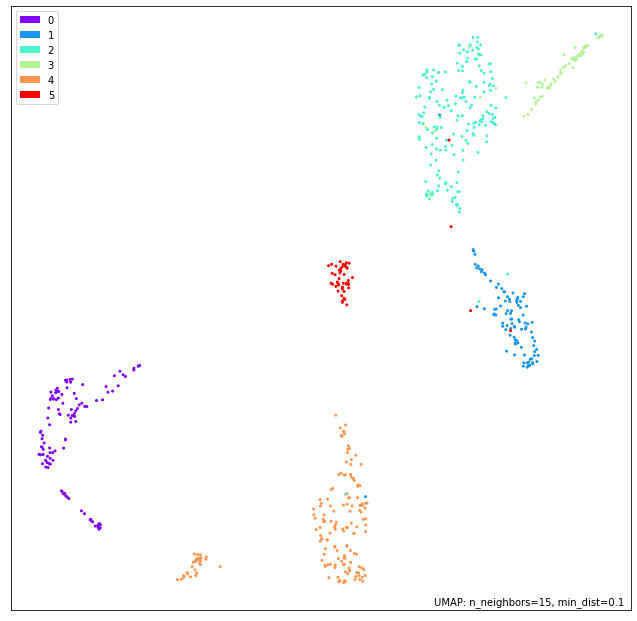

In [26]:
# the featureDict could contain more parameters, use '?umap.UMAP' for more details.
featureDict={
        'n_neighbors' : 15,
        'min_dist' : 0.1,   
        'metric' : 'euclidean',
        }

mapper = umap.UMAP(**featureDict).fit(predicted_Probability_after_pool)
plotObj = umap.plot.points(mapper, labels=testLabelArr, color_key_cmap='rainbow', background='white')
plt.show()

Using a loop for multiple plotting with different parameters.

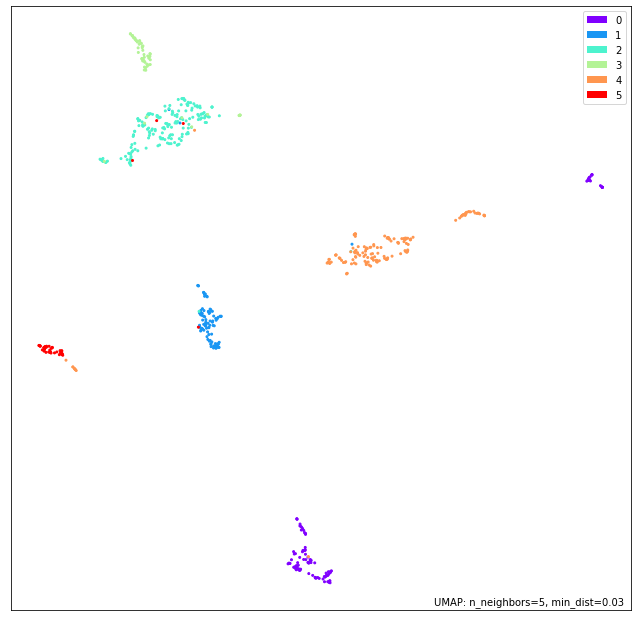

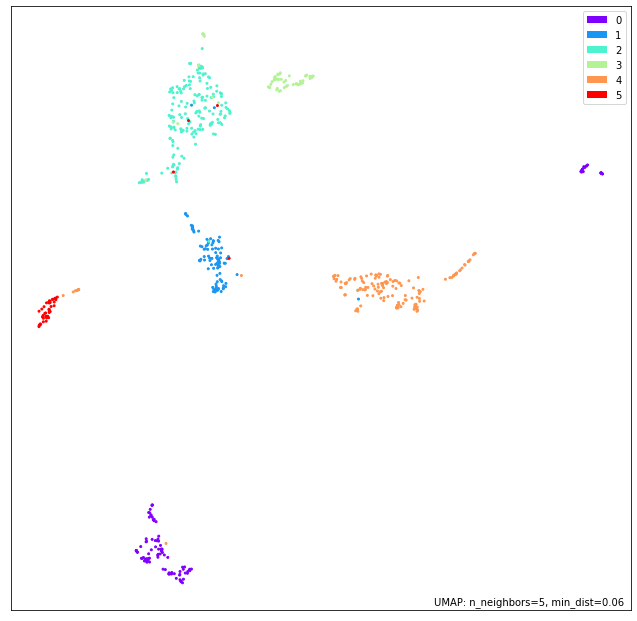

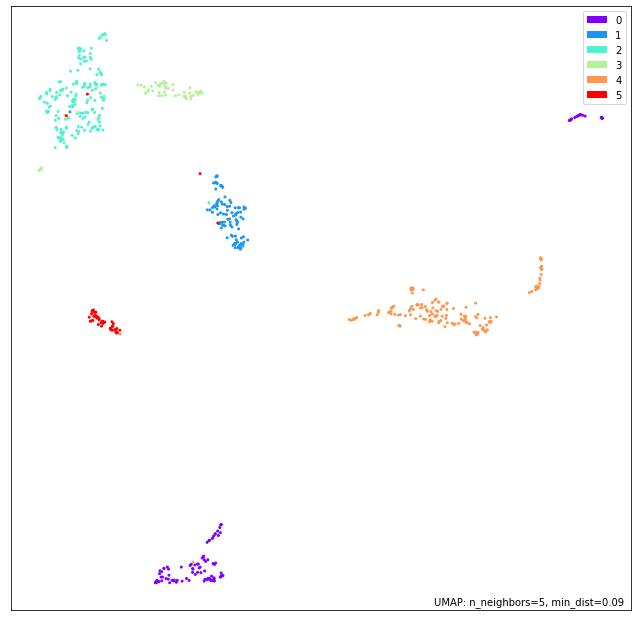

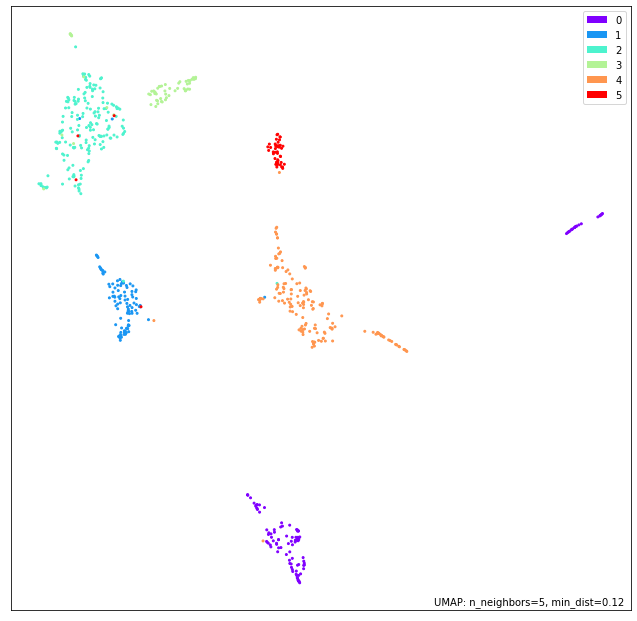

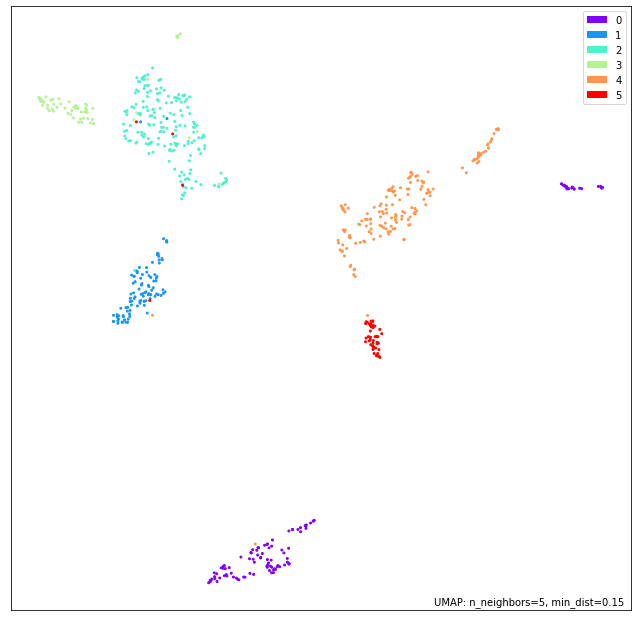

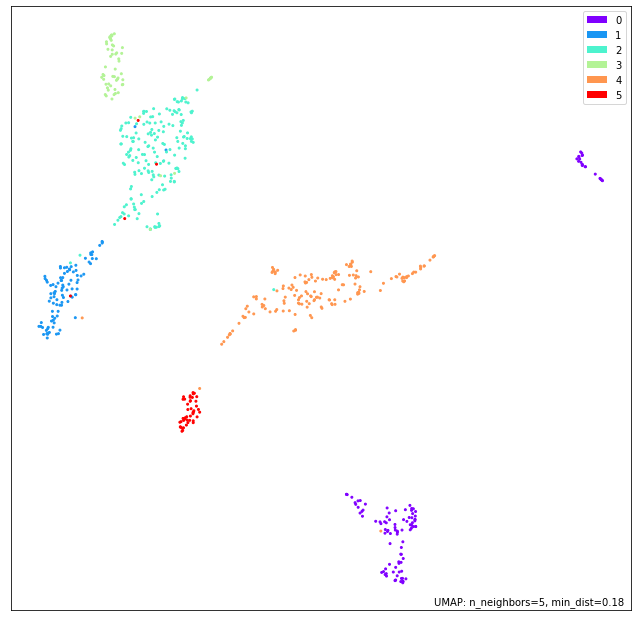

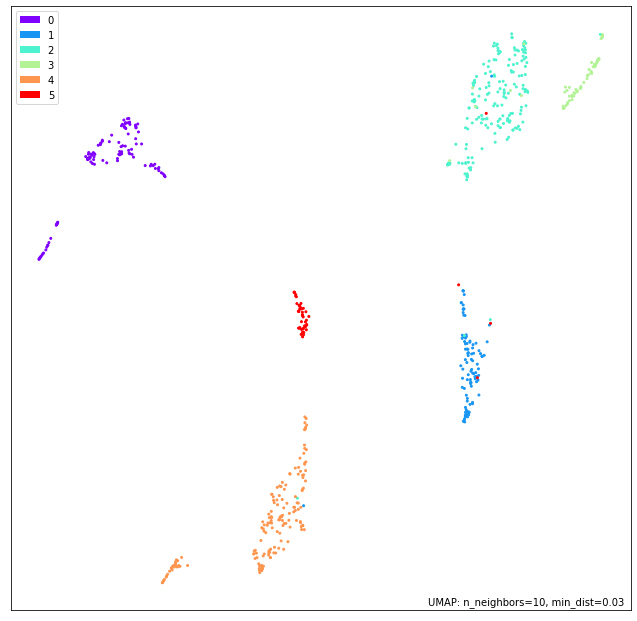

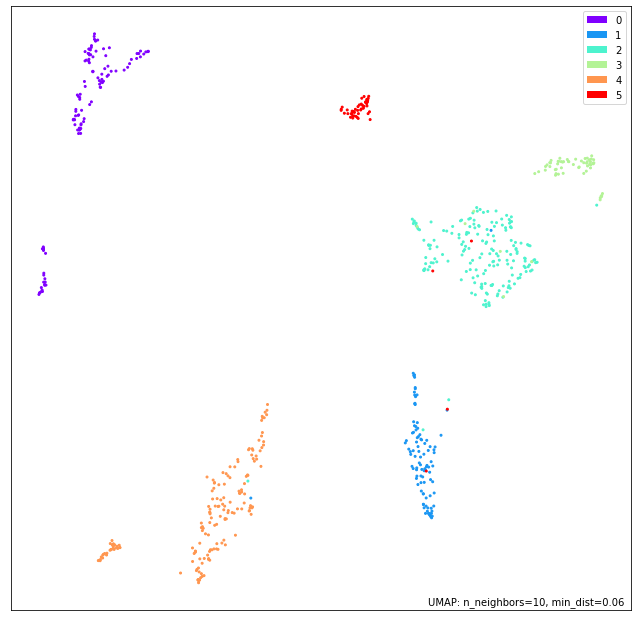

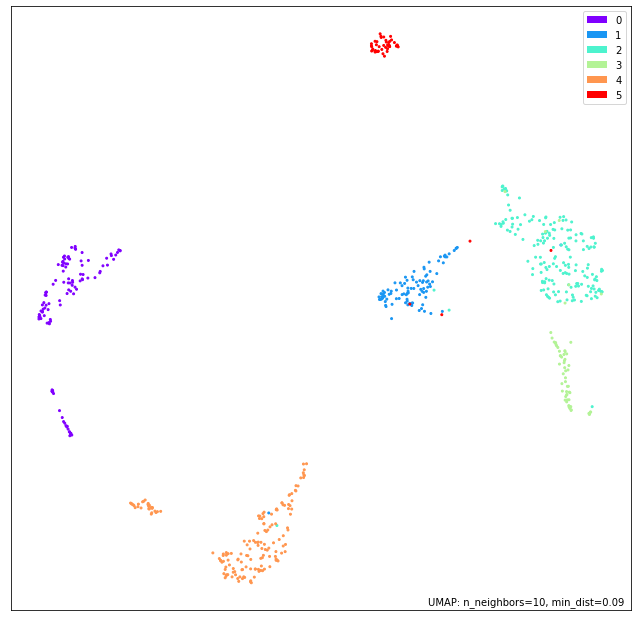

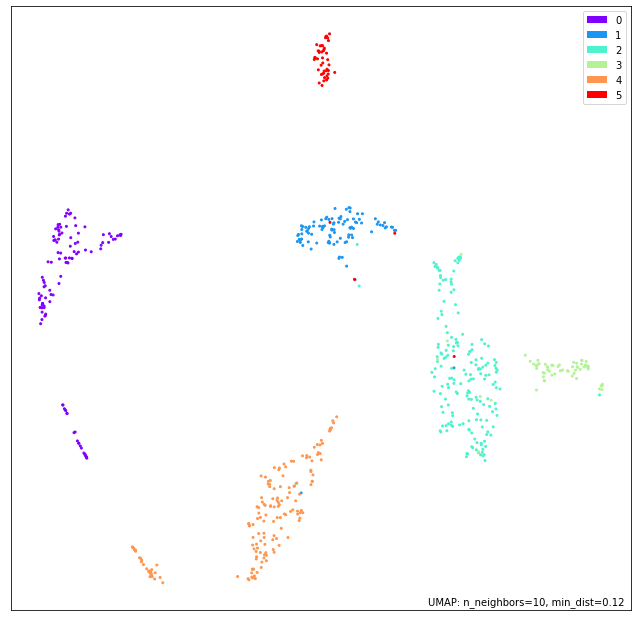

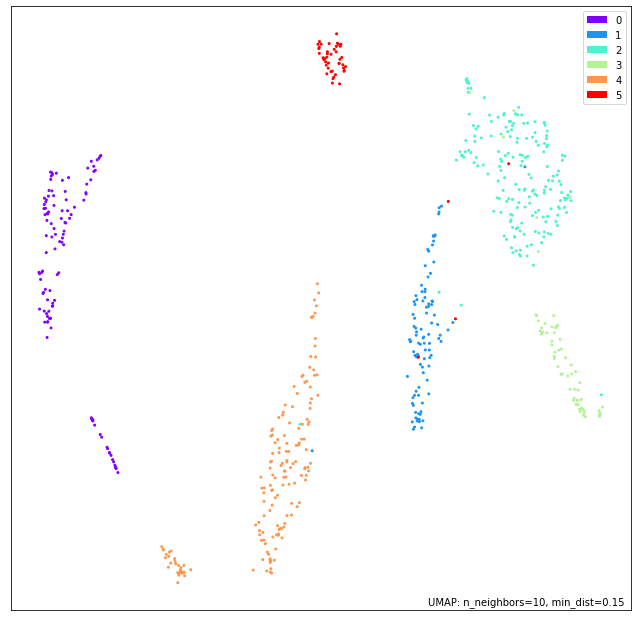

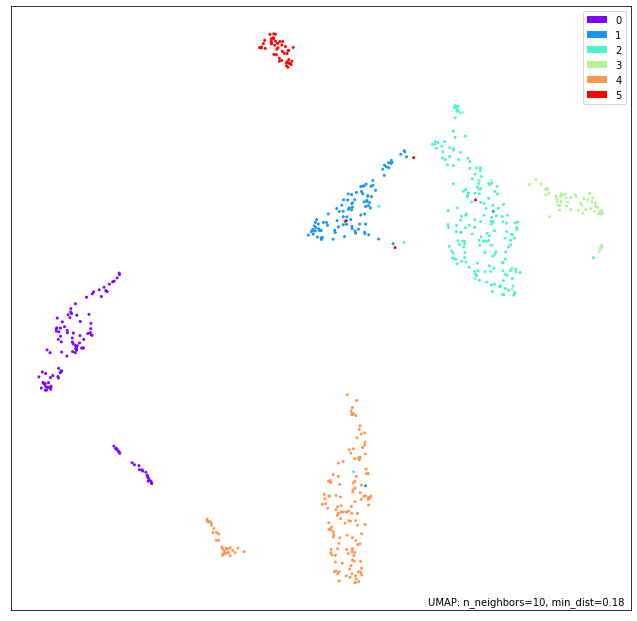

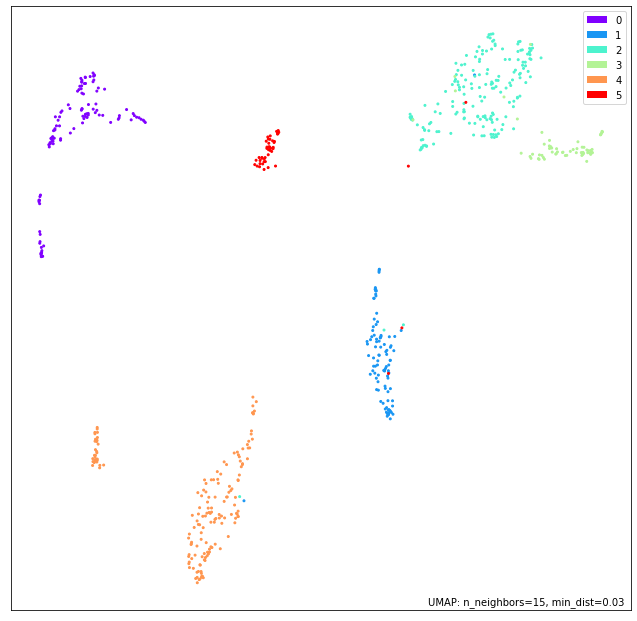

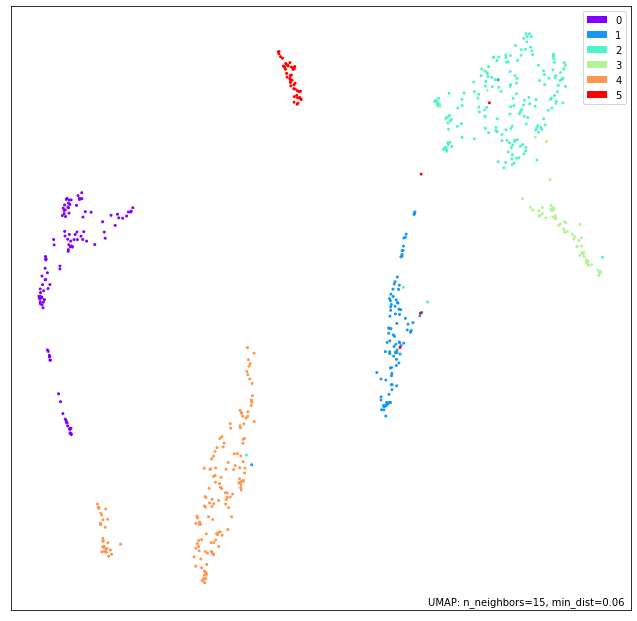

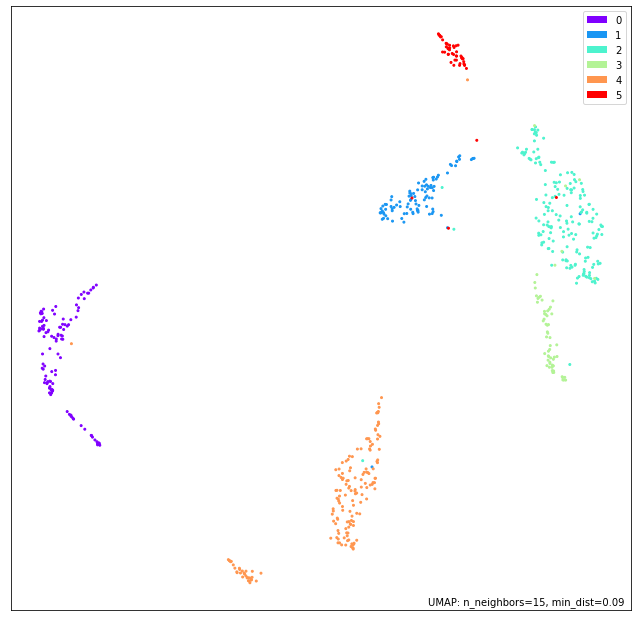

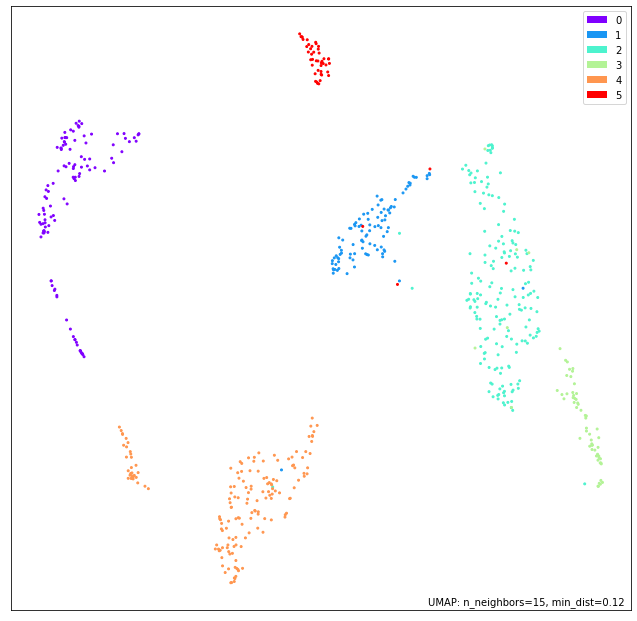

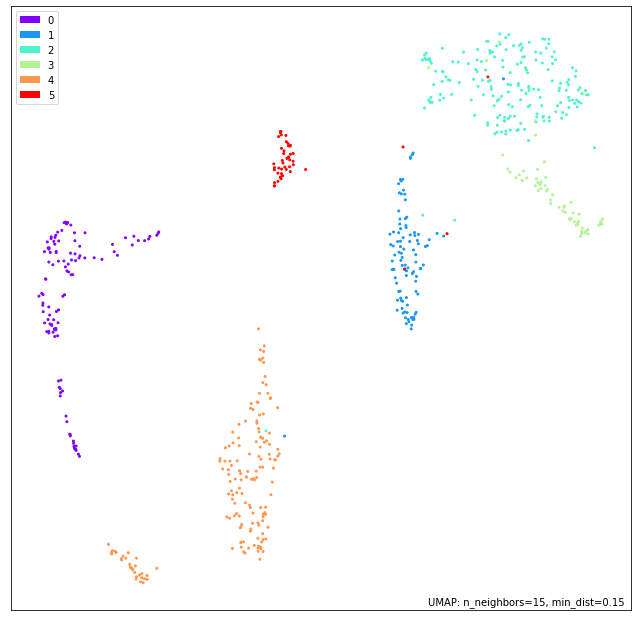

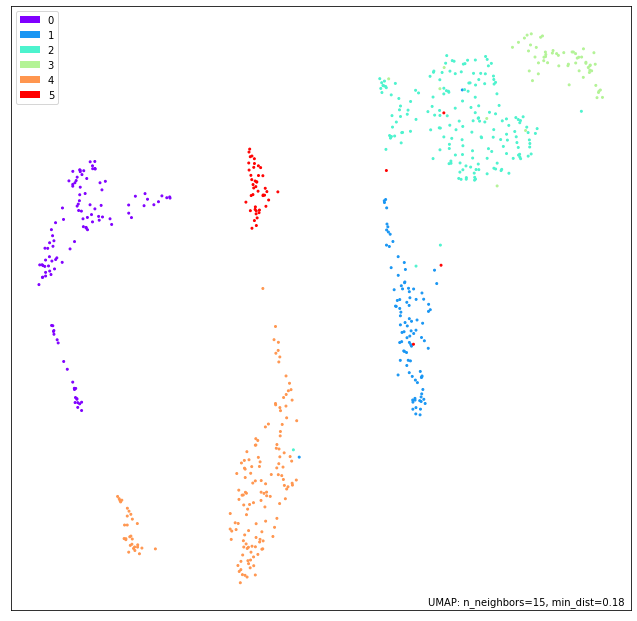

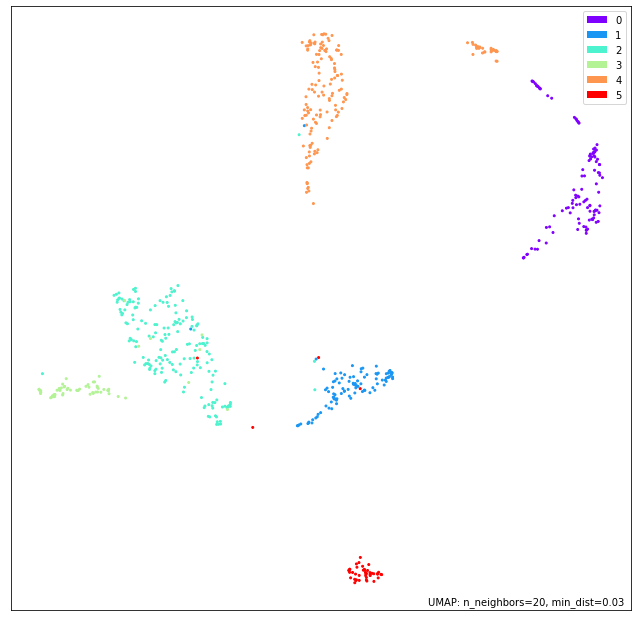

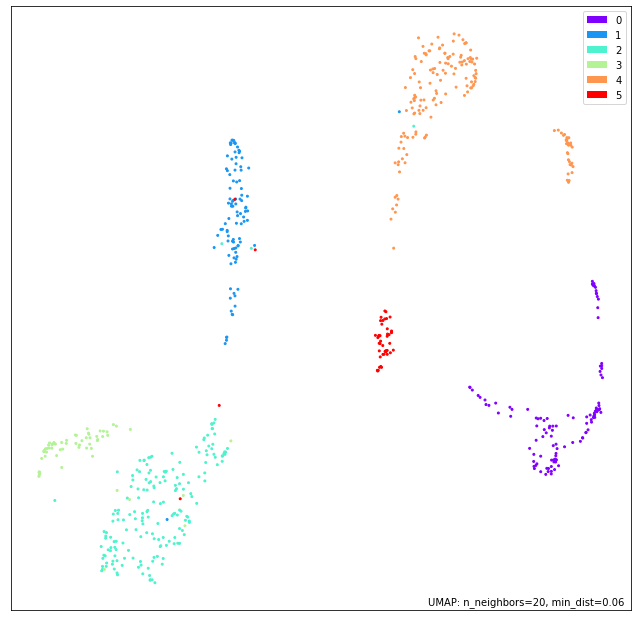

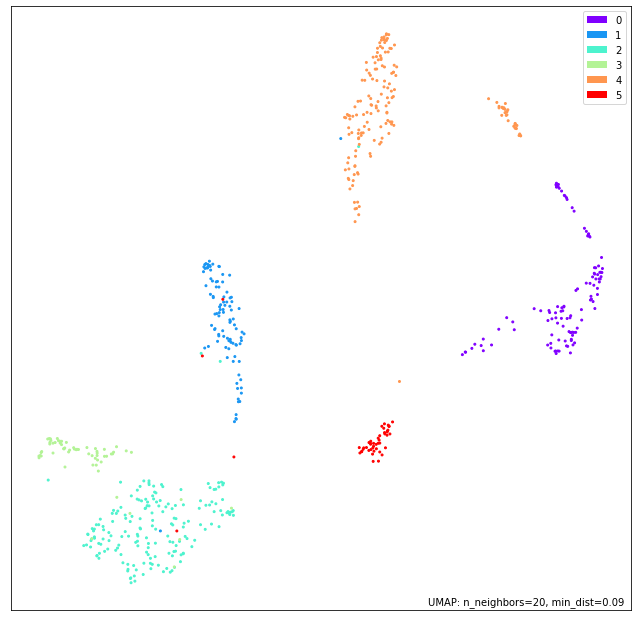

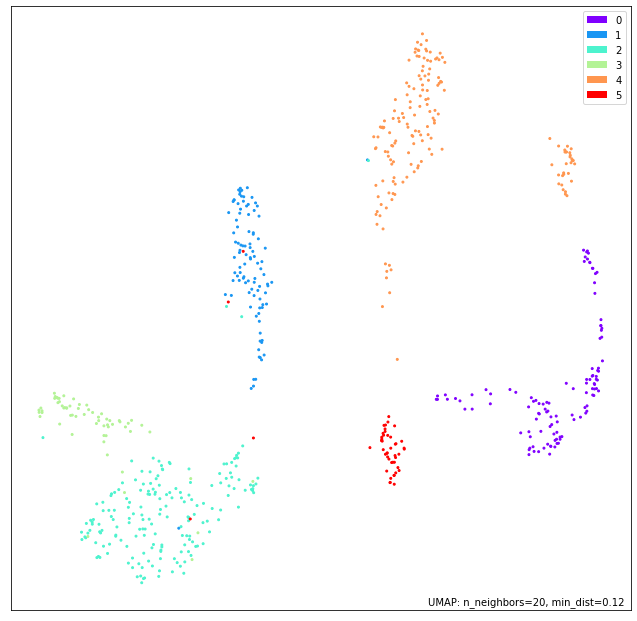

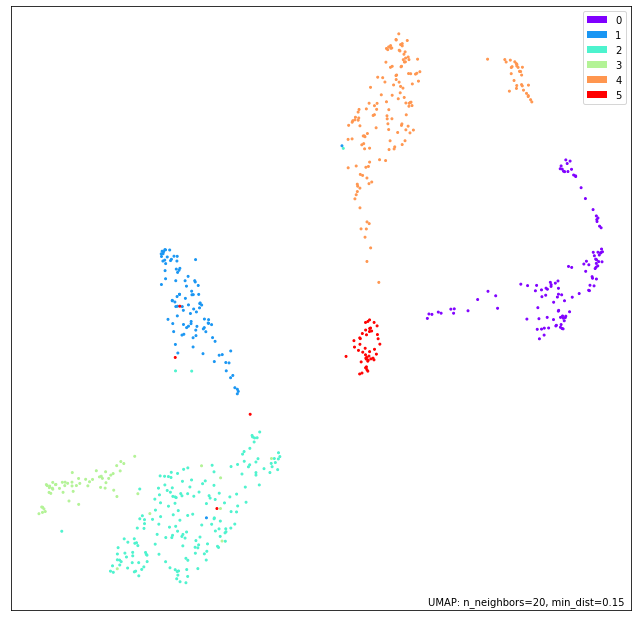

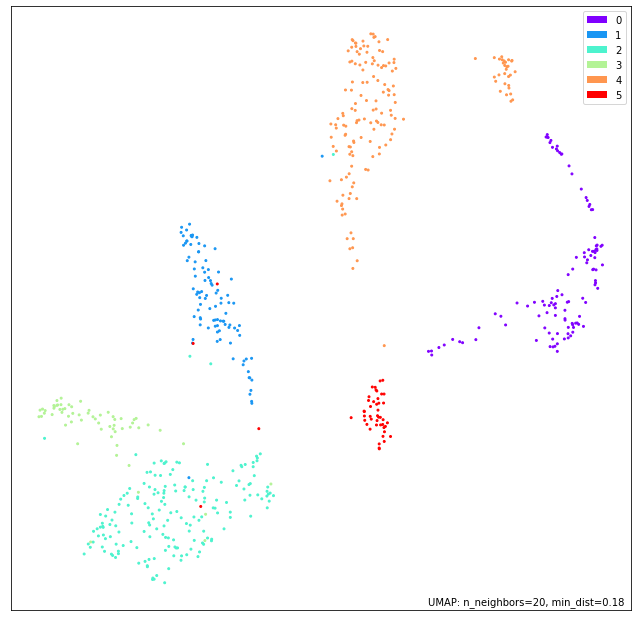

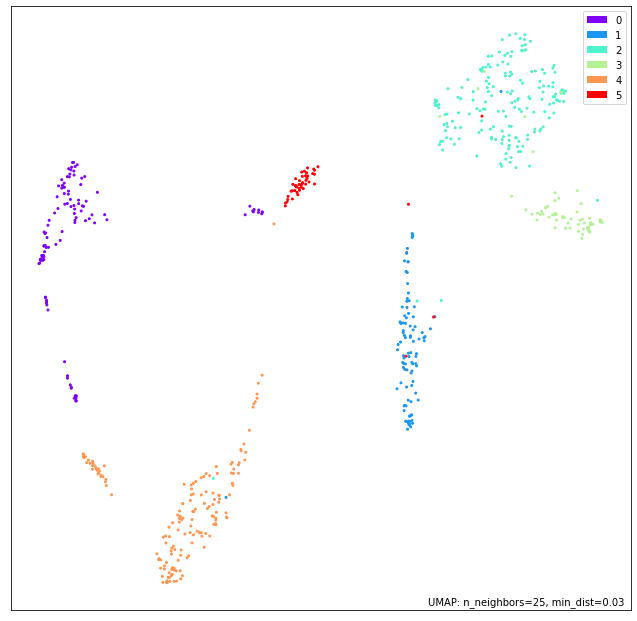

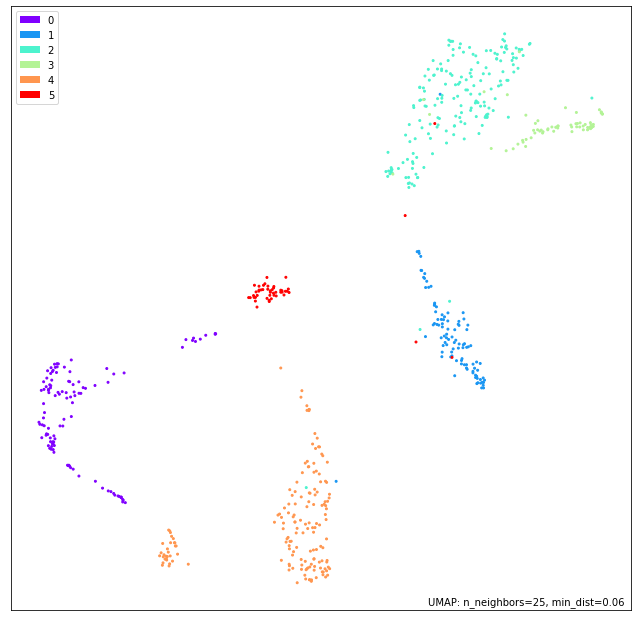

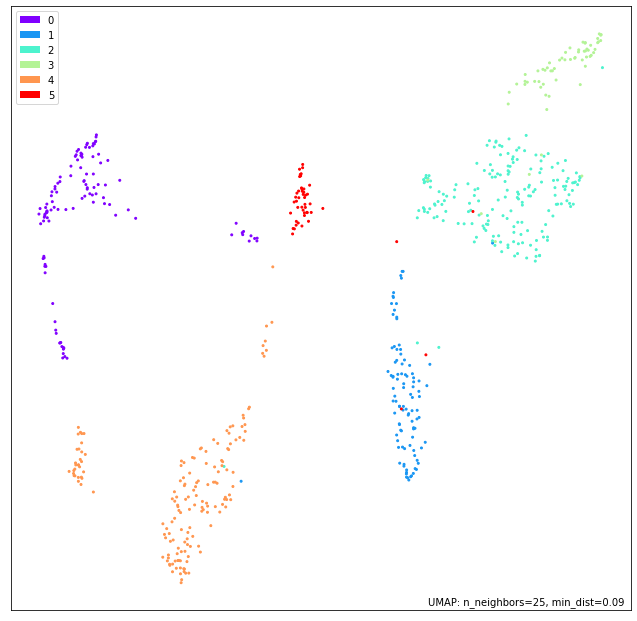

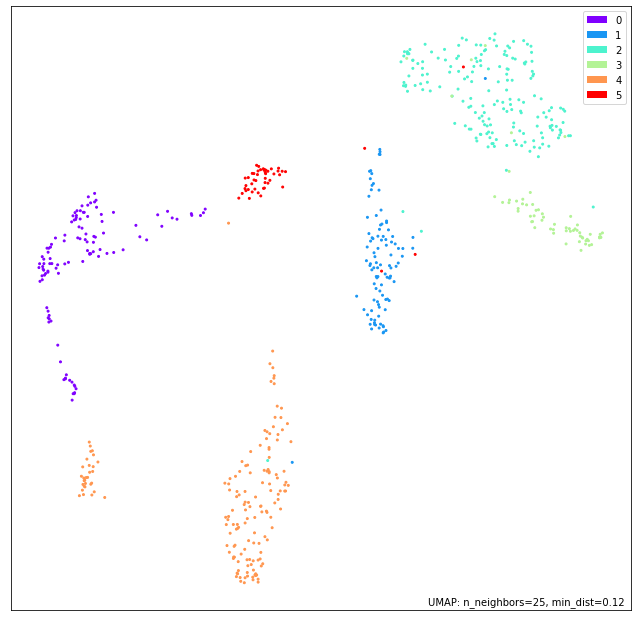

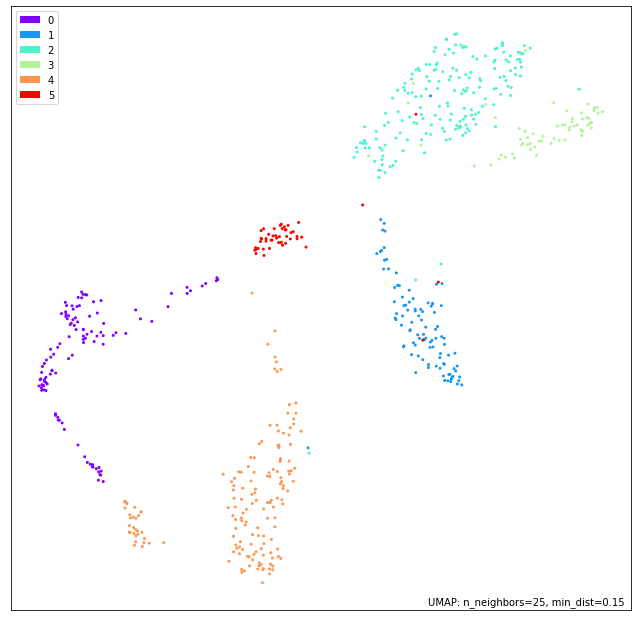

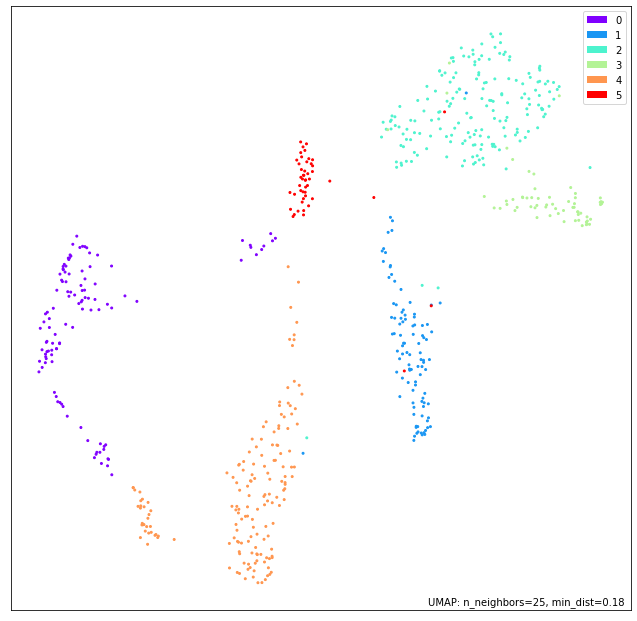

In [32]:
featureDict={
        'n_neighbors' : 15,
        'min_dist' : 0.1,
        'metric' : 'euclidean',

        }
for n_neighbors in np.arange(5,30,5).astype(int):
    featureDict['n_neighbors'] = n_neighbors
    for min_dist in np.arange(0.03,0.2,0.03):
        featureDict['min_dist'] = min_dist
        mapper = umap.UMAP(**featureDict).fit(predicted_Probability_after_pool)
        plotObj = umap.plot.points(mapper, labels=testLabelArr, color_key_cmap='rainbow')
        plt.show()
        plt.close() #close the plotted figure 

<h3>2.2 Plotting for the output before the pooling layer</h3>

The shape of intermediate data is 3-d, thus need a reduce operating before the plotting.

In [28]:
newModel_before_pool = Sequential()
for layer in layers[:3]:
    newModel_before_pool.add(layer)
newModel_before_pool.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         6656      
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         320250    
Total params: 326,906
Trainable params: 326,906
Non-trainable params: 0
_________________________________________________________________


In [29]:
predicted_Probability_before_pool = newModel_before_pool.predict(testDataMats)

In [30]:
predicted_Probability_before_pool.shape

(667, 1996, 250)

Here we simply use np.mean for dimensional reduce.

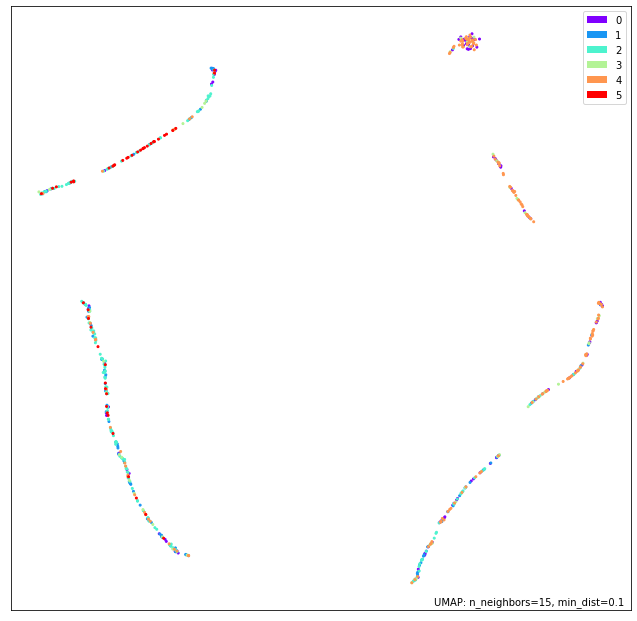

In [31]:
# the featureDict could contain more parameters, use '?umap.UMAP' for more details.
featureDict={
        'n_neighbors' : 15,
        'min_dist' : 0.1,   
        'metric' : 'euclidean',
        }

mapper = umap.UMAP(**featureDict).fit(np.mean(predicted_Probability_before_pool,axis=2))
plotObj = umap.plot.points(mapper, labels=testLabelArr, color_key_cmap='rainbow', background='white')
plt.show()

Plotting with different paramenters.

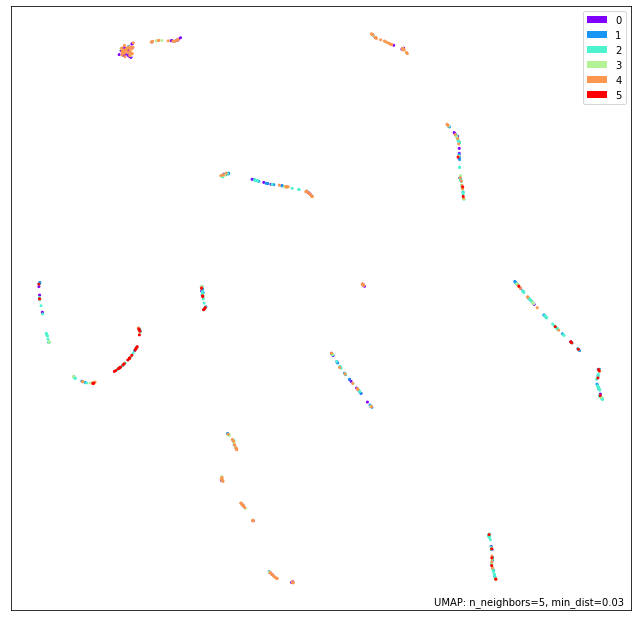

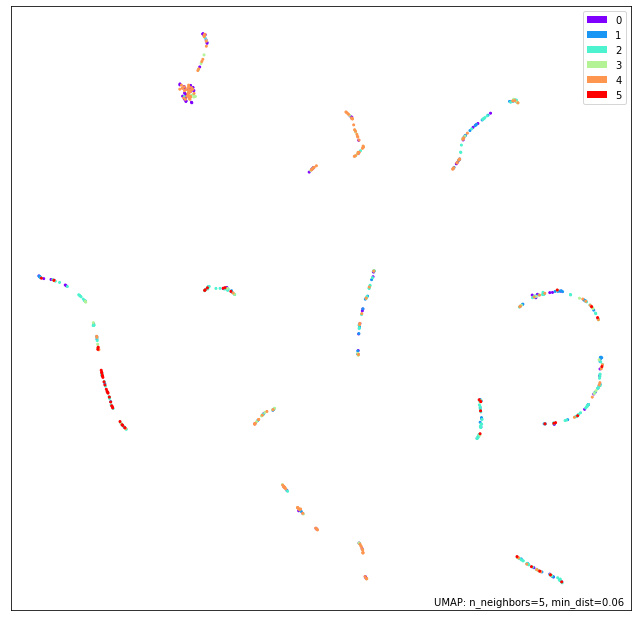

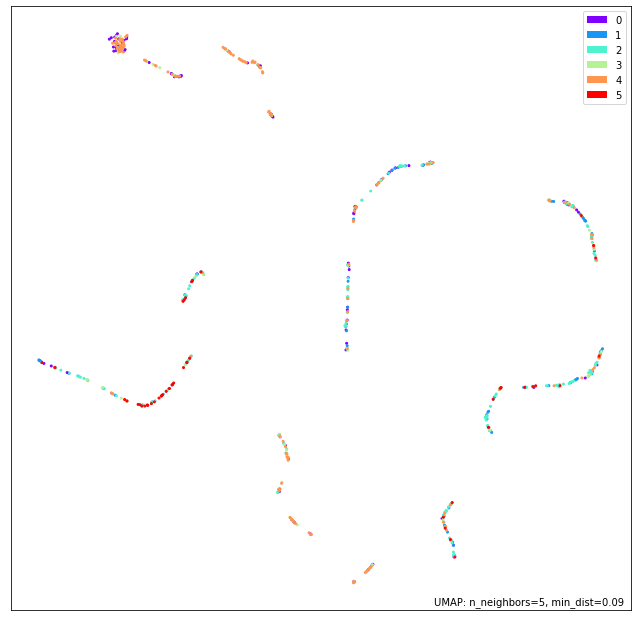

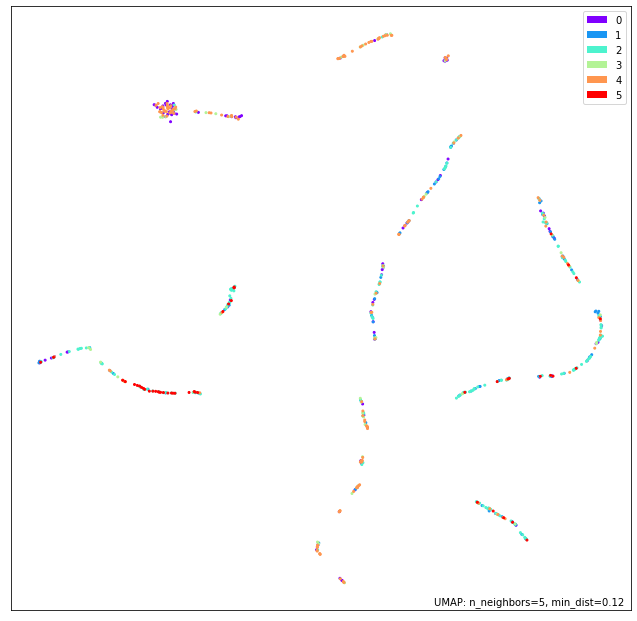

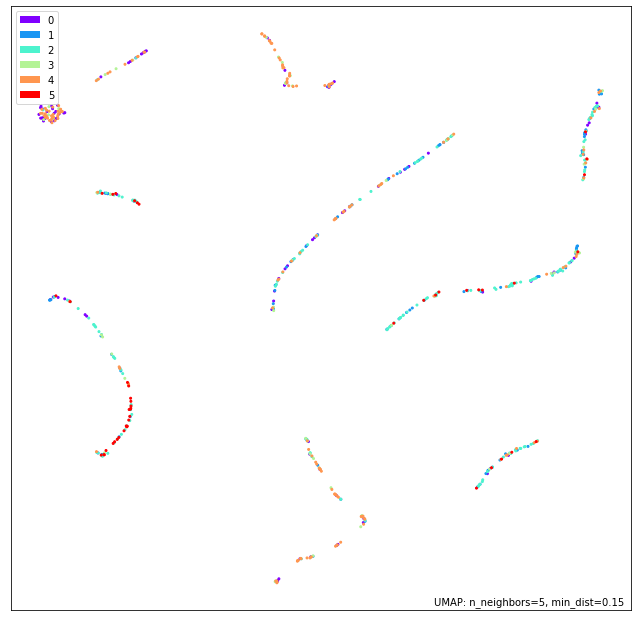

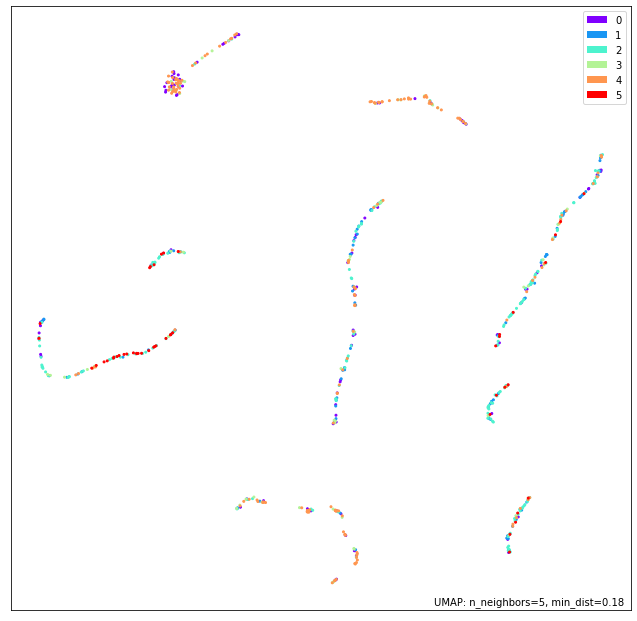

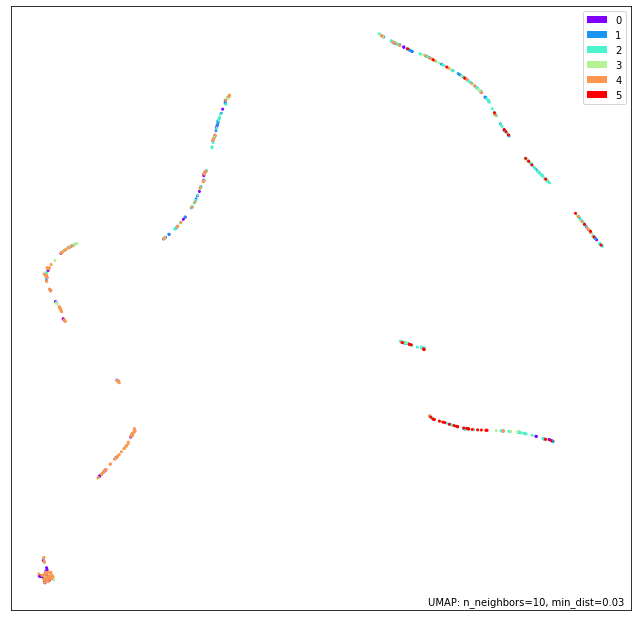

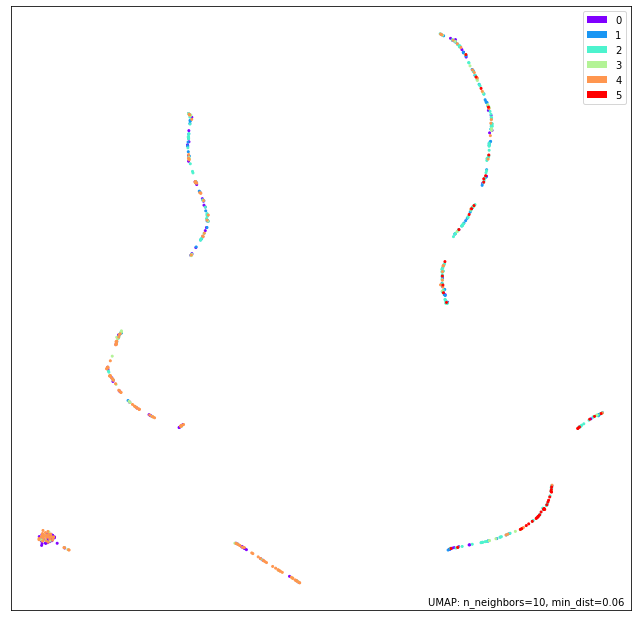

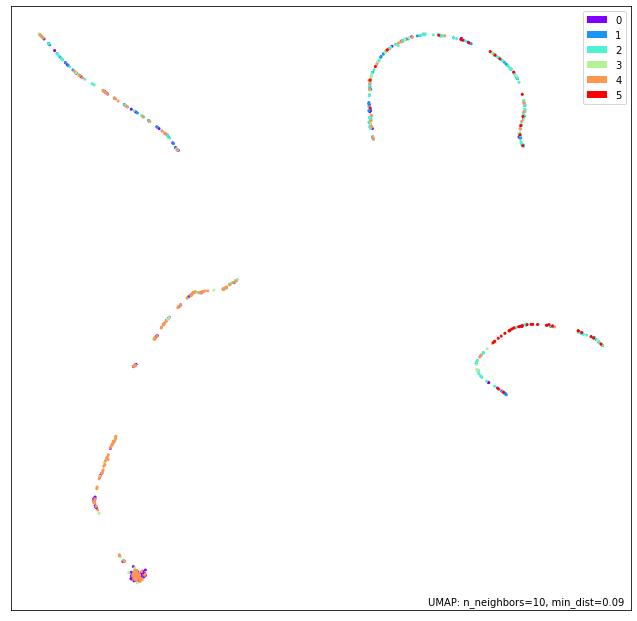

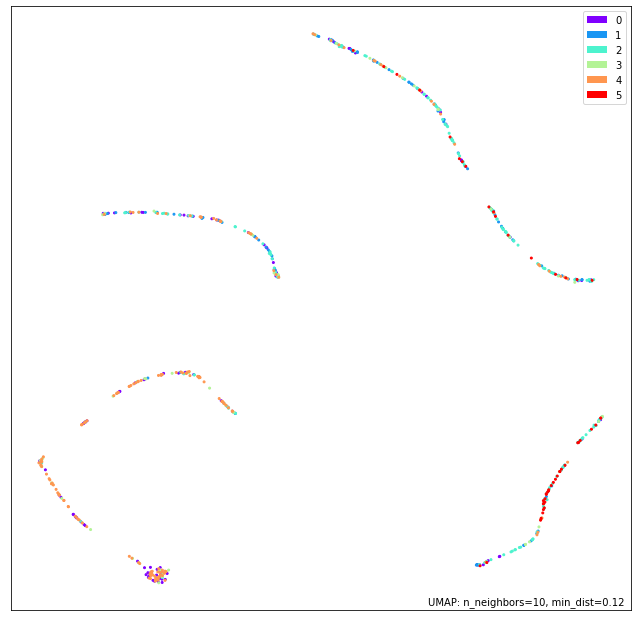

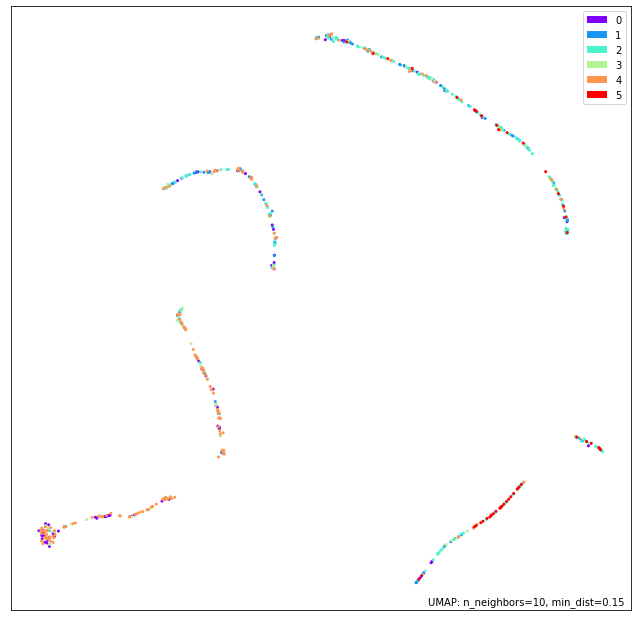

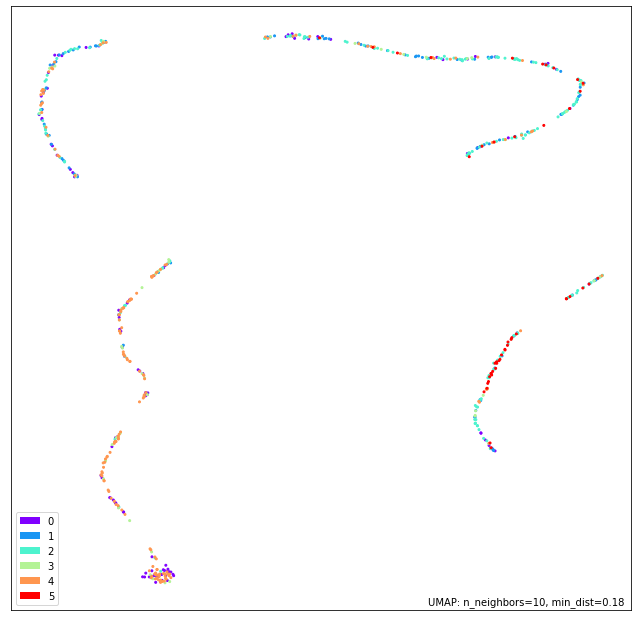

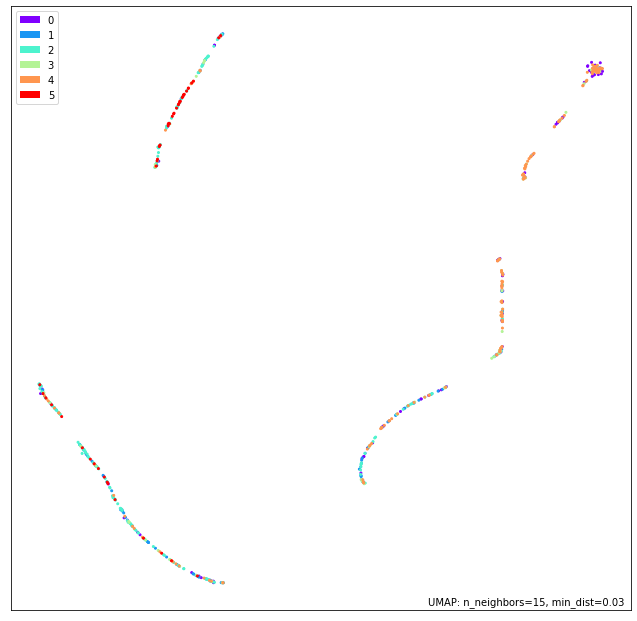

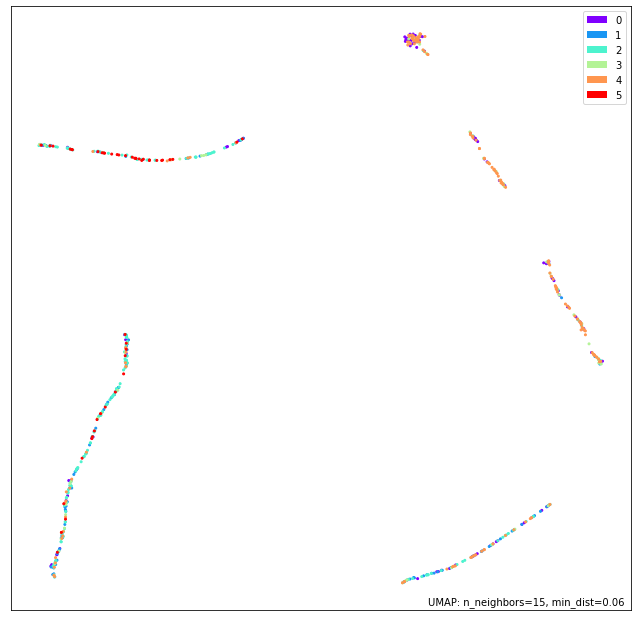

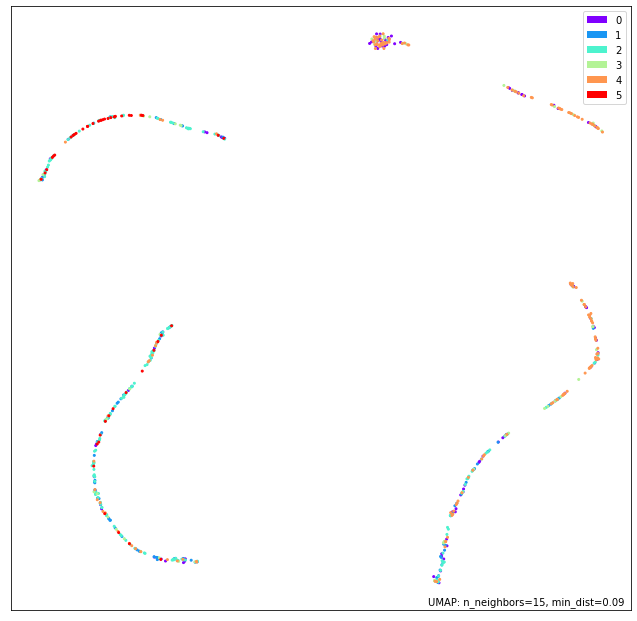

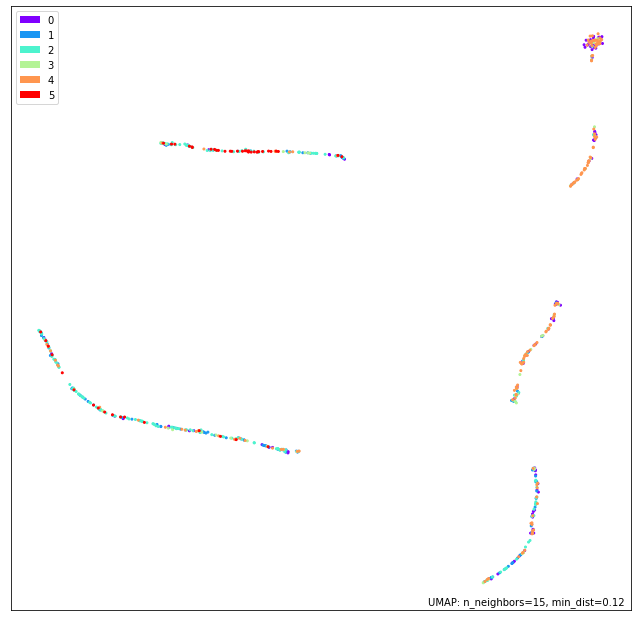

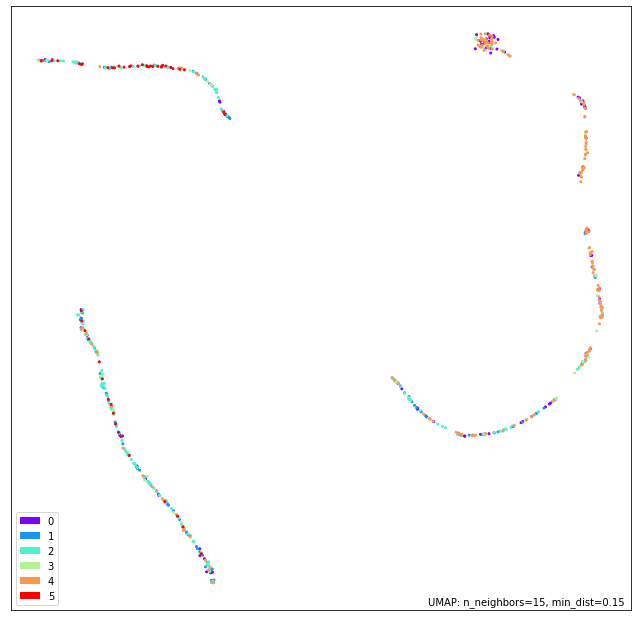

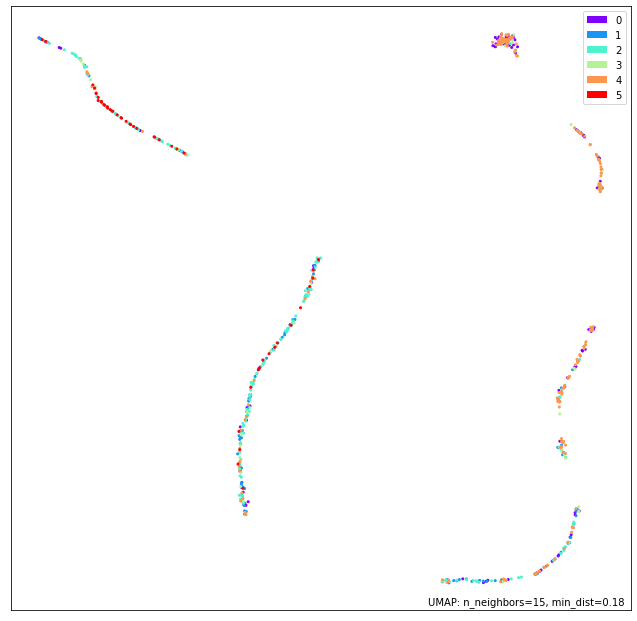

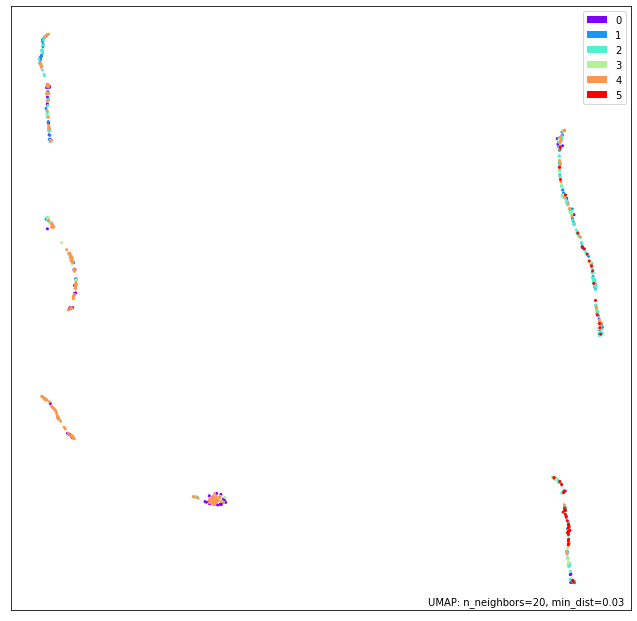

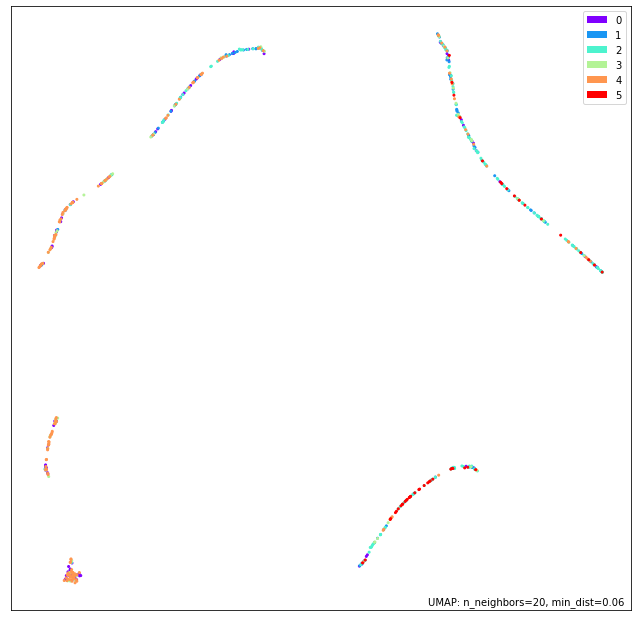

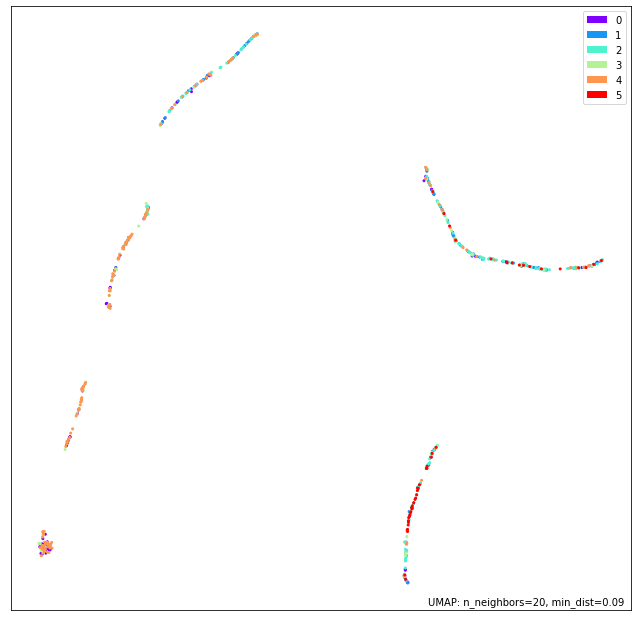

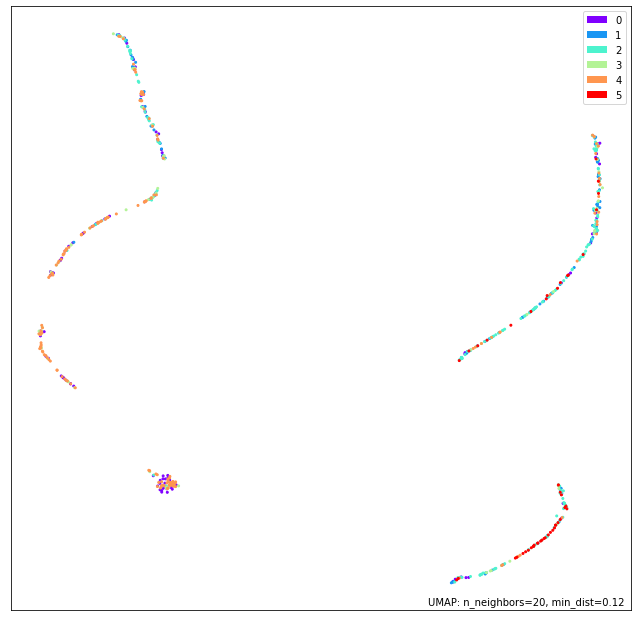

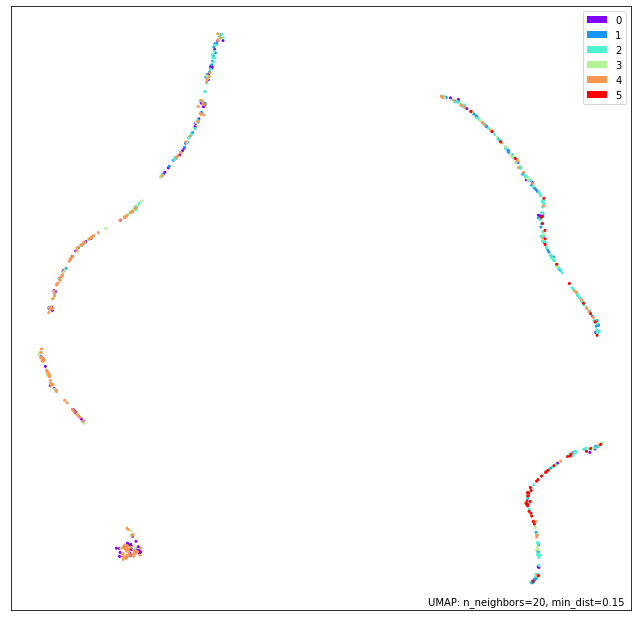

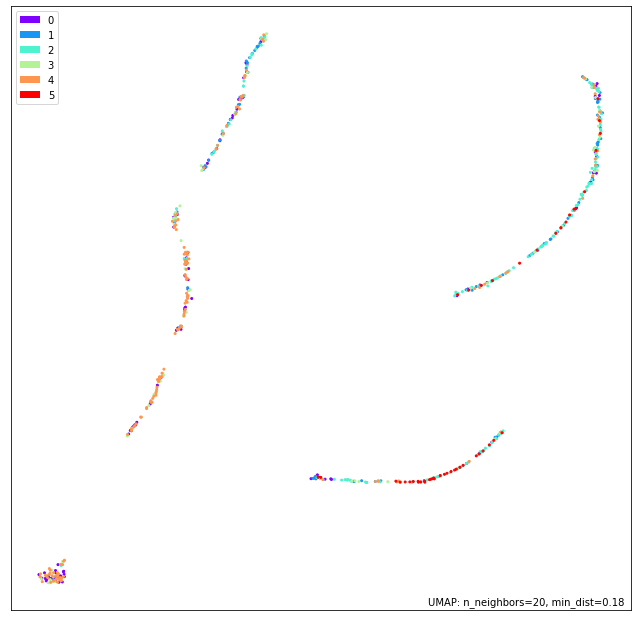

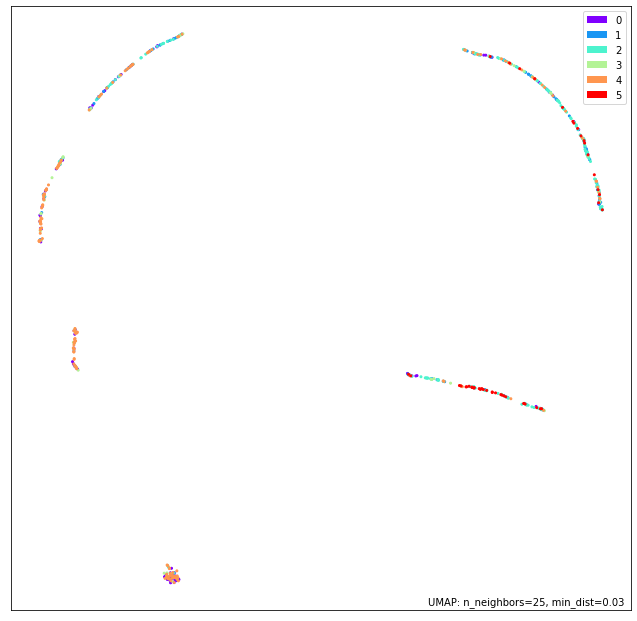

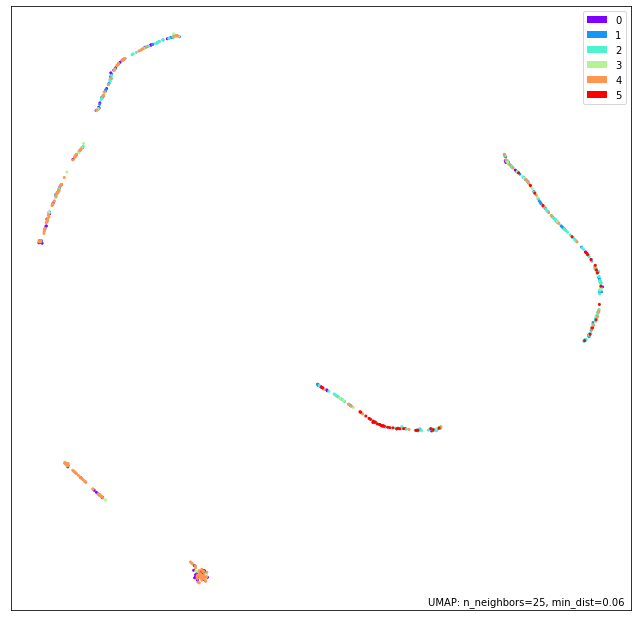

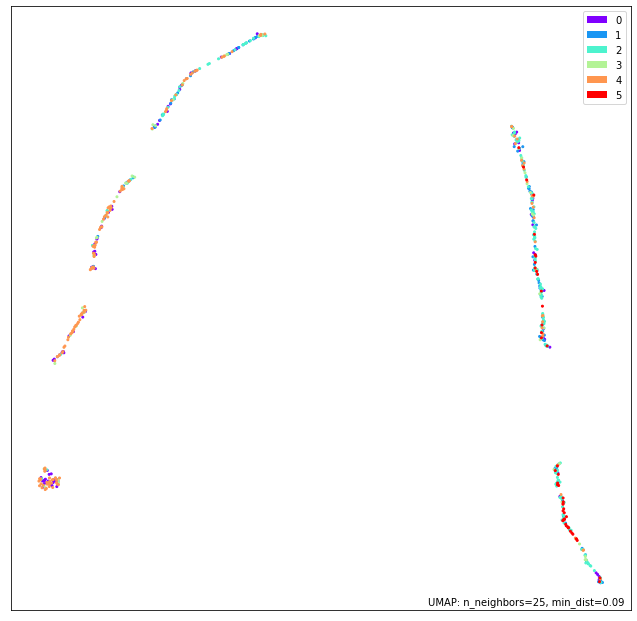

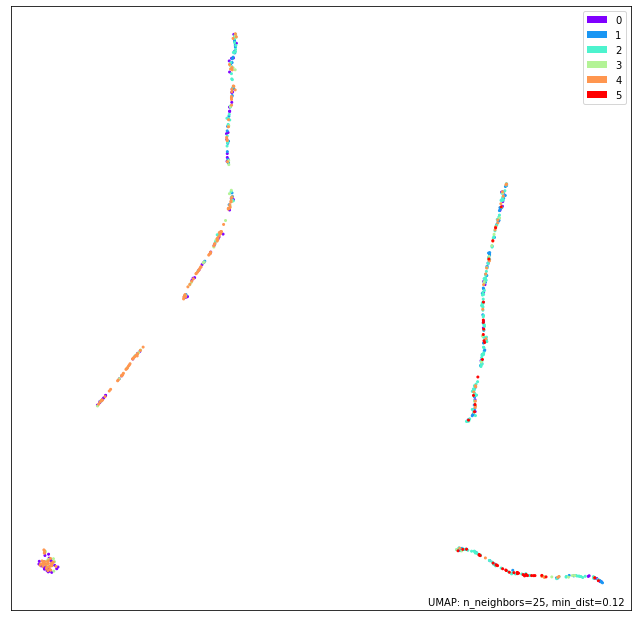

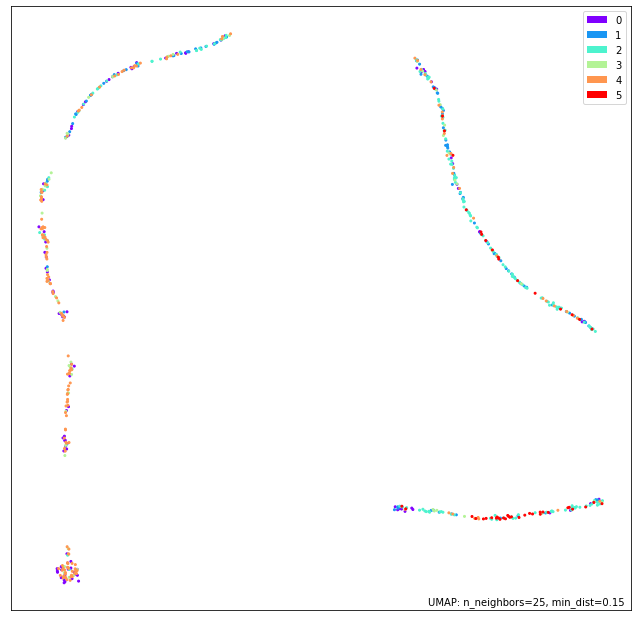

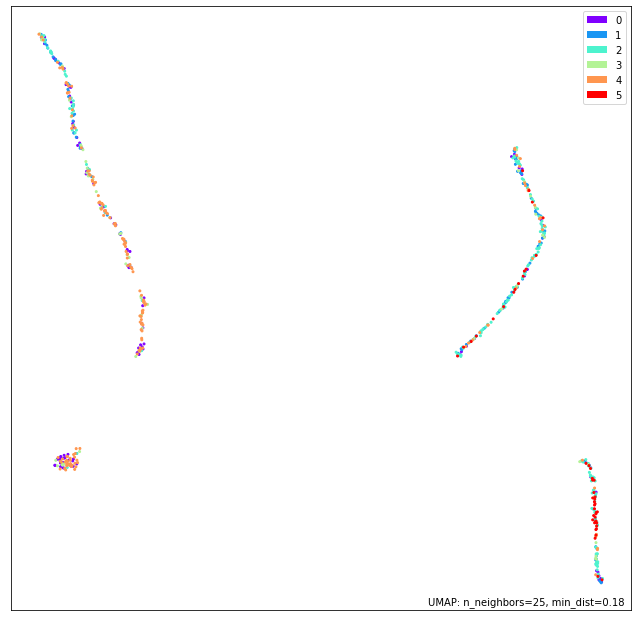

In [34]:
featureDict={
        'n_neighbors' : 15,
        'min_dist' : 0.1,
        'metric' : 'euclidean',

        }
for n_neighbors in np.arange(5,30,5).astype(int):
    featureDict['n_neighbors'] = n_neighbors
    for min_dist in np.arange(0.03,0.2,0.03):
        featureDict['min_dist'] = min_dist
        mapper = umap.UMAP(**featureDict).fit(np.mean(predicted_Probability_before_pool,axis=2))
        plotObj = umap.plot.points(mapper, labels=testLabelArr, color_key_cmap='rainbow')
        plt.show()
        plt.close() #close the plotted figure 

That's all the informations for plotting the layer of multi-label. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.